In [13]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import json
import seaborn as sns

api = wandb.Api()


In [14]:
pubmed_mlp=api.run("luisawerner/nesy23/3vol5qrs").summary['test_accuracies']
pubmed_kenn_mlp=api.run("luisawerner/nesy23/2tnphpvq").summary['test_accuracies']
pubmed_gcn=api.run("luisawerner/nesy23/sml5bi91").summary['test_accuracies']
pubmed_kenn_gcn=api.run("luisawerner/nesy23/2bkseqxp").summary['test_accuracies']
pubmed_gat = api.run("luisawerner/nesy23/2tnswjml").summary['test_accuracies']
pubmed_kenn_gat = api.run("luisawerner/nesy23/1fv9jhuv").summary['test_accuracies']

import torch_geometric.datasets
[pubmed_dataset] = torch_geometric.datasets.Planetoid(root='PubMed', name='PubMed', split="full")
num_classes = 3
color = plt.cm.rainbow(np.linspace(0, 1, num_classes))

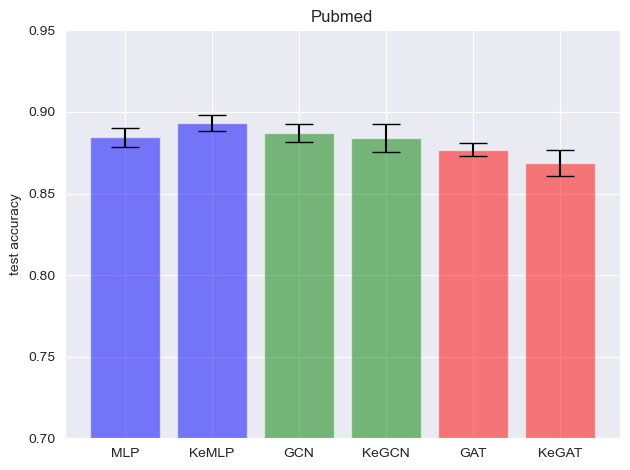

Mean Average Test Accuracy over 50 runs: 
MLP: 0.8844399999999999 (0.005738153012947638), KeMLP: 0.8930599999999999 (0.004768270126576308)
GCN: 0.8870199999999998 (0.0053497289650972085), KeGCN: 0.884 (0.008708616422830905)
GAT: 0.87688 (0.003957979282411673), KeGAT: 0.8687599999999999 (0.008130338246346219)


p-value KeMLP > MLP for PubMed: 8.243639036545687e-13
p-value KeGCN > GCN for PubMed: 0.9793811522051503
p-value KeGAT > GAT for PubMed: 0.9999999954683192


In [15]:
# PubMed
color_h=['blue', 'blue', 'green', 'green', 'red', 'red']
xpos = np.arange(6)
means = [np.mean(pubmed_mlp), np.mean(pubmed_kenn_mlp), np.mean(pubmed_gcn), np.mean(pubmed_kenn_gcn), np.mean(pubmed_gat), np.mean(pubmed_kenn_gat)]
errors = [np.std(pubmed_mlp), np.std(pubmed_kenn_mlp), np.std(pubmed_gcn), np.std(pubmed_kenn_gcn), np.std(pubmed_gat), np.std(pubmed_kenn_gat)]
fig, ax = plt.subplots()
ax.bar(xpos, means, yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=10, color=color_h)
ax.set_ylabel('test accuracy')
ax.set_xticks(xpos)
ax.set_xticklabels(['MLP', 'KeMLP', 'GCN', 'KeGCN', 'GAT', 'KeGAT'])
ax.set_title('Pubmed')
ax.yaxis.grid(True)

# Save the figure and show
plt.ylim(0.7, 0.95)
plt.tight_layout()
plt.savefig('figures/results_pubmed.pdf', format='pdf')
plt.show()

print(f'Mean Average Test Accuracy over {len(pubmed_mlp)} runs: ')
print(f'MLP: {np.mean(pubmed_mlp)} ({np.std(pubmed_mlp)}), KeMLP: {np.mean(pubmed_kenn_mlp)} ({np.std(pubmed_kenn_mlp)})' )
print(f'GCN: {np.mean(pubmed_gcn)} ({np.std(pubmed_gcn)}), KeGCN: {np.mean(pubmed_kenn_gcn)} ({np.std(pubmed_kenn_gcn)})' )
print(f'GAT: {np.mean(pubmed_gat)} ({np.std(pubmed_gat)}), KeGAT: {np.mean(pubmed_kenn_gat)} ({np.std(pubmed_kenn_gat)})' )
print ('\n')
print(f'p-value KeMLP > MLP for PubMed: {scipy.stats.ttest_ind(pubmed_kenn_mlp, pubmed_mlp, alternative="greater")[1]}')
print(f'p-value KeGCN > GCN for PubMed: {scipy.stats.ttest_ind(pubmed_kenn_gcn, pubmed_gcn, alternative="greater")[1]}')
print(f'p-value KeGAT > GAT for PubMed: {scipy.stats.ttest_ind(pubmed_kenn_gat, pubmed_gat, alternative="greater")[1]}')


In [16]:
import numpy as np
def compute_compliance(data, num_classes):
    """
    compute clause compliance per iteration
    returns a list of length |number classes| with compliance value per each
    """
    # y = model.data.y.cpu().detach().numpy() do we need to detach or is this even slowing down the code?
    y = data.y.numpy()
    edge_index = np.transpose(data.edge_index.numpy())
    train_mask = data.train_mask.numpy()
    train_edge_mask = np.logical_or(train_mask[edge_index[:, 0]], train_mask[edge_index[:, 1]])

    # calculate the classes corresponding to edge index
    edge_index_cls = np.zeros_like(edge_index)
    for row in range(edge_index.shape[0]):
        edge_index_cls[row, 0] = y[edge_index[row, 0]]
        edge_index_cls[row, 1] = y[edge_index[row, 1]]

    compliance = []
    for cls in range(num_classes):
        cls_mask = np.logical_or(edge_index_cls[:, 0] == cls, edge_index_cls[:, 1] == cls)
        mask = np.logical_and(cls_mask, train_edge_mask) # edges that have at least a training node and a node of class cls
        same_mask = np.logical_and(mask, np.equal(edge_index_cls[:, 0], edge_index_cls[:, 1])) # edges that are of the above set and have the same class for both nodes
        cls_compliance = sum(same_mask)/sum(mask)
        compliance.append(cls_compliance)

    return compliance

In [17]:
print(f'Compliance Cora: {compute_compliance(pubmed_dataset, num_classes=num_classes)}')

Compliance Cora: [0.4921793534932221, 0.7432938400779607, 0.6903725205611998]


In [18]:

num_runs = 50
# for Cora
pubmed_keMLP = eval(api.run("luisawerner/nesy23/2tnphpvq").summary['logged_clause_weights'])
pubmed_keGCN = eval(api.run("luisawerner/nesy23/2bkseqxp").summary['logged_clause_weights'])
pubmed_keGAT = eval(api.run("luisawerner/nesy23/1fv9jhuv").summary['logged_clause_weights'])

In [19]:
# KeMLP
num_layers = 2
# print clause weights of last epoch
for cls in range(num_classes):
    for layer in range(num_layers):
        cls_list = [pubmed_keMLP[i][layer][str(cls)][1] for i in range(num_runs)]
        print(f'Class {cls}, Layer {layer}: Mean clause weight {np.mean(cls_list)}, std clause weight: {np.std(cls_list)}')


Class 0, Layer 0: Mean clause weight 0.00804861990007339, std clause weight: 0.02194698660561983
Class 0, Layer 1: Mean clause weight 0.007927649058401584, std clause weight: 0.021580759043052032
Class 1, Layer 0: Mean clause weight 0.0743556019035168, std clause weight: 0.07597727684305167
Class 1, Layer 1: Mean clause weight 0.0706548953615129, std clause weight: 0.06995154976874667
Class 2, Layer 0: Mean clause weight 0.03792090380564332, std clause weight: 0.03990003756495839
Class 2, Layer 1: Mean clause weight 0.037497372563229873, std clause weight: 0.03900627608636647


In [20]:
#KeGCN
num_layers=1
for cls in range(num_classes):
    for layer in range(num_layers):
        cls_list = [pubmed_keGCN[i][layer][str(cls)][1] for i in range(num_runs)]
        print(f'Class {cls}, Layer {layer}: Mean clause weight {np.mean(cls_list)}, std clause weight: {np.std(cls_list)}')


Class 0, Layer 0: Mean clause weight 0.4549818195030093, std clause weight: 0.2914318393497584
Class 1, Layer 0: Mean clause weight 0.37402109494432806, std clause weight: 0.2348548035037939
Class 2, Layer 0: Mean clause weight 0.45398010592907667, std clause weight: 0.25980569227118794


In [21]:
#KeGAT
num_layers=5
for cls in range(num_classes):
    for layer in range(num_layers):
        cls_list = [pubmed_keGAT[i][layer][str(cls)][1] for i in range(num_runs)]
        print(f'Class {cls}, Layer {layer}: Mean clause weight {np.mean(cls_list)}, std clause weight: {np.std(cls_list)}')


Class 0, Layer 0: Mean clause weight 0.5806922614574432, std clause weight: 0.0021606102826185565
Class 0, Layer 1: Mean clause weight 0.5569398725032806, std clause weight: 0.013488328482291801
Class 0, Layer 2: Mean clause weight 0.4184143513441086, std clause weight: 0.04617298872061934
Class 0, Layer 3: Mean clause weight 0.28779822677373884, std clause weight: 0.05552549284259561
Class 0, Layer 4: Mean clause weight 0.2706136780977249, std clause weight: 0.05657568194707434
Class 1, Layer 0: Mean clause weight 0.41400643408298493, std clause weight: 0.006181238369589682
Class 1, Layer 1: Mean clause weight 0.4056757545471191, std clause weight: 0.02926918638941936
Class 1, Layer 2: Mean clause weight 0.3972145411372185, std clause weight: 0.10513570784751224
Class 1, Layer 3: Mean clause weight 0.41970221638679506, std clause weight: 0.12656244032217145
Class 1, Layer 4: Mean clause weight 0.4281514871120453, std clause weight: 0.1287518910781832
Class 2, Layer 0: Mean clause weig

Class 0, Layer 0: Mean of learned clause weight over runs: 2.5539577651023864, std clause weight: 0.3153591117140713
Class 0, Layer 1: Mean of learned clause weight over runs: 0.3519339214079082, std clause weight: 0.16636836323093518
Class 1, Layer 0: Mean of learned clause weight over runs: 2.8543548583984375, std clause weight: 0.23260879154752873
Class 1, Layer 1: Mean of learned clause weight over runs: 0.6824250799417496, std clause weight: 0.21222162533405572
Class 2, Layer 0: Mean of learned clause weight over runs: 2.3546578168869017, std clause weight: 0.2281424386064925
Class 2, Layer 1: Mean of learned clause weight over runs: 0.5468858277797699, std clause weight: 0.2008544737648782
Citeseer Compliance: [0.4921793534932221, 0.7432938400779607, 0.6903725205611998, nan, nan, nan]


/var/folders/1n/gv8zs7ld72g24l1skjhbh30c0000gn/T/ipykernel_80260/780124016.py:24: RuntimeWarning: invalid value encountered in long_scalars
  cls_compliance = sum(same_mask)/sum(mask)


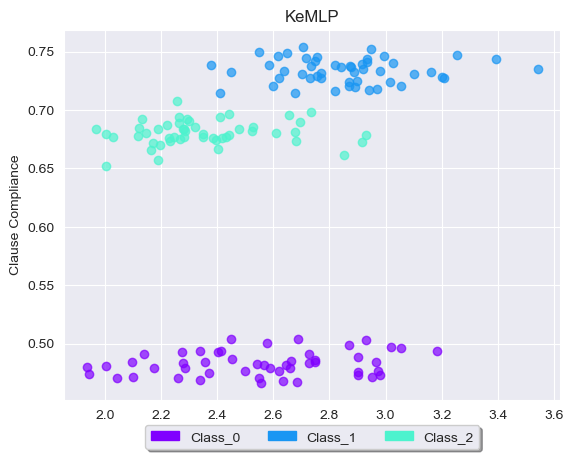

In [24]:
# KeMLP

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import json
import seaborn as sns
color = plt.cm.rainbow(np.linspace(0, 1, 6))

num_layers=2
for cls in range(num_classes):
    for layer in range(num_layers):
        cls_list = [pubmed_keMLP[i][layer][str(cls)][-1] for i in range(50)]
        print(f'Class {cls}, Layer {layer}: Mean of learned clause weight over runs: {np.mean(cls_list)}, std clause weight: {np.std(cls_list)}')

plt.figure()

pubmed_compliance = compute_compliance(pubmed_dataset, num_classes=6)
print(f'Citeseer Compliance: {pubmed_compliance}')

patches = []
for k, j in enumerate(['0', '1', '2']):
    patches.append(mpatches.Patch(color=color[k], label='Class_'+j))
    _list = [pubmed_keMLP[i][0][j][-1] for i in range(50)]
    for i in _list:
        plt.scatter(i, pubmed_compliance[k] + np.random.normal(-0.01, 0.01)
                    , color=color[k], alpha=0.7)

plt.ylabel('Clause Compliance')
plt.xlabel('Clause Weights (over all epochs)')
#plt.legend(handles=patches)
# plt.title(f'Clause weight distribution vs. Clause Compliance, initialization = {0.5}')
plt.title('KeMLP')
plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
# plt.savefig('figures/CiteSeer_KeMLP_clauseweights.pdf', format='pdf', bbox_inches = 'tight')
plt.show()


# plot clause weight evolution over epochs


Class 0, Layer 0: Mean of learned clause weight over runs: 0.5201899750903248, std clause weight: 0.39477173139790084
Class 1, Layer 0: Mean of learned clause weight over runs: 0.15026180451735854, std clause weight: 0.21465868688097614
Class 2, Layer 0: Mean of learned clause weight over runs: 0.028631194054614752, std clause weight: 0.17666520617240294
Citeseer Compliance: [0.4921793534932221, 0.7432938400779607, 0.6903725205611998]


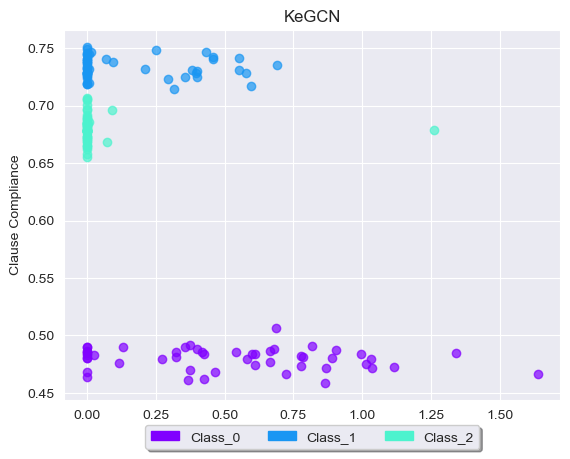

In [25]:
# KeGCN

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import json
import seaborn as sns
color = plt.cm.rainbow(np.linspace(0, 1, 6))

num_layers=1
for cls in range(num_classes):
    for layer in range(num_layers):
        cls_list = [pubmed_keGCN[i][layer][str(cls)][-1] for i in range(50)]
        print(f'Class {cls}, Layer {layer}: Mean of learned clause weight over runs: {np.mean(cls_list)}, std clause weight: {np.std(cls_list)}')

plt.figure()

pubmed_compliance = compute_compliance(pubmed_dataset, num_classes=num_classes)
print(f'Citeseer Compliance: {pubmed_compliance}')

patches = []
for k, j in enumerate(['0', '1', '2']):
    patches.append(mpatches.Patch(color=color[k], label='Class_'+j))
    _list = [pubmed_keGCN[i][0][j][-1] for i in range(50)]
    for i in _list:
        plt.scatter(i, pubmed_compliance[k] + np.random.normal(-0.01, 0.01)
                    , color=color[k], alpha=0.7)

plt.ylabel('Clause Compliance')
plt.xlabel('Clause Weights (over all epochs)')
#plt.legend(handles=patches)
# plt.title(f'Clause weight distribution vs. Clause Compliance, initialization = {0.5}')
plt.title('KeGCN')
plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
# plt.savefig('figures/CiteSeer_KeMLP_clauseweights.pdf', format='pdf', bbox_inches = 'tight')
plt.show()


# plot clause weight evolution over epochs


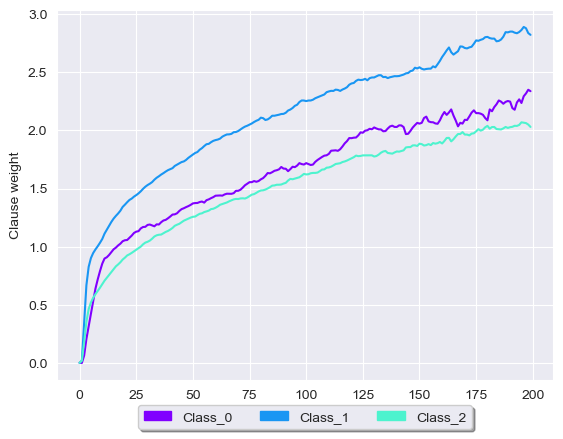

In [30]:
run = 19
#13, 16, 22
patches = []
for k, j in enumerate(['0', '1', '2']):
    patches.append(mpatches.Patch(color=color[k], label='Class_' + j))
    _list = pubmed_keMLP[run][0][j]
    plt.plot(_list, color=color[k])
plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=5)
plt.ylabel('Clause weight')
plt.xlabel('Epoch')
# plt.savefig('figures/CiteSeer_KeGCN_cw_evolution.pdf', format='pdf', bbox_inches = 'tight')
plt.show()

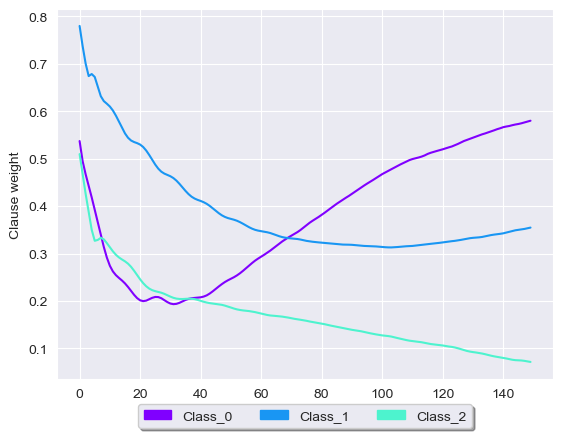

In [29]:

run = 19
#13, 16, 22
patches = []
for k, j in enumerate(['0', '1', '2']):
    patches.append(mpatches.Patch(color=color[k], label='Class_' + j))
    _list = pubmed_keGCN[run][0][j]
    plt.plot(_list, color=color[k])
plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=5)
plt.ylabel('Clause weight')
plt.xlabel('Epoch')
# plt.savefig('figures/CiteSeer_KeGCN_cw_evolution.pdf', format='pdf', bbox_inches = 'tight')
plt.show()